To allow inline pictures, run the following block

In [1]:
%matplotlib inline

Import the useful libraries

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import math
colors = ['red', 'green', 'blue', 'purple', 'slategrey', 'brown', 'darkorange', 'black']

Data to read

In [3]:
dataPath = '../Generator'
dataFile = 'JC-Experiments.xlsx'

To be sure that the **Experiments.xlsx** file is in the current directory, run the following block by clicking CTRL+ENTER

In [4]:
import os
print("List of files of directory:", os.path.abspath(os.getcwd()+'/'+dataPath))
os.listdir(os.getcwd()+'/'+dataPath)

List of files of directory: /home/pantale/SynologyDrive/Programming/Python/ANN-ConstitutiveLaw/Generator


['OriginalData100.svg',
 'OriginalData20.svg',
 'OriginalData300.svg',
 'OriginalData500.svg',
 'JC-Experiments.xlsx',
 'OriginalData200.svg',
 '.ipynb_checkpoints',
 'Johnson-Cook.ipynb']

Read the content of the Excel file using the pandas library method read_excel.

In [5]:
excelData = pd.read_excel(dataPath+'/'+dataFile, None)

Extract list of temperatures from the name of sheets

In [6]:
len(excelData)
temperatures = []
temps = list(excelData.keys())
for T in temps:
    temperatures.append(int(T.replace('°C','')))
temperaturesOrig = temperatures
temperatures

[20, 100, 200, 300, 500]

Get the values of epsp

In [7]:
dataSheet = excelData[str(temperatures[0])+'°C']
epsp = []
for i in range(1, dataSheet.shape[1]):
    epsp.append(dataSheet.columns[i])
epspOrig = epsp
epsp

[0.1, 1, 50, 1000, 500000]

Extract data from the panda sheets

In [8]:
# Read first sheet
dataSheet = excelData[str(temperatures[0])+'°C']
data = dataSheet.values
eps = data[:,0]
sig = data[:,1:]
# Append the other sheets
for T in temperatures[1:]:
    dataSheet = excelData[str(T)+'°C']
    data = dataSheet.values
    sig = np.append(sig, data[:,1:], axis=1)

In [9]:
temperatures = np.array(temperatures)
epsp = np.log(np.array(epsp)/0.1)
epspArray = np.tile(epsp,temperatures.shape[0])
temperaturesArray = temperatures.repeat(epsp.shape[0])
epspArray, temperaturesArray

(array([ 0.        ,  2.30258509,  6.2146081 ,  9.21034037, 15.42494847,
         0.        ,  2.30258509,  6.2146081 ,  9.21034037, 15.42494847,
         0.        ,  2.30258509,  6.2146081 ,  9.21034037, 15.42494847,
         0.        ,  2.30258509,  6.2146081 ,  9.21034037, 15.42494847,
         0.        ,  2.30258509,  6.2146081 ,  9.21034037, 15.42494847]),
 array([ 20,  20,  20,  20,  20, 100, 100, 100, 100, 100, 200, 200, 200,
        200, 200, 300, 300, 300, 300, 300, 500, 500, 500, 500, 500]))

In [10]:
entries = np.empty([epspArray.shape[0]*eps.shape[0], 4])
row = 0
colEps = 0
colEpsp = 1
colT = 2
colSig = 3
for i in range(epspArray.shape[0]):
    for j in range(eps.shape[0]):
        entries[row, colEps] = eps[j]
        entries[row, colEpsp] = epspArray[i]
        entries[row, colT] = temperaturesArray[i]
        entries[row, colSig] = sig[j,i]
        row += 1
entries

array([[0.00000000e+00, 0.00000000e+00, 2.00000000e+01, 8.06000000e+02],
       [2.04081633e-02, 0.00000000e+00, 2.00000000e+01, 1.12531214e+03],
       [4.08163265e-02, 0.00000000e+00, 2.00000000e+01, 1.16474716e+03],
       ...,
       [9.59183673e-01, 1.54249485e+01, 5.00000000e+02, 1.15698156e+03],
       [9.79591837e-01, 1.54249485e+01, 5.00000000e+02, 1.15874710e+03],
       [1.00000000e+00, 1.54249485e+01, 5.00000000e+02, 1.16048230e+03]])

In [11]:
maxEntries = entries.max(axis=0)

In [12]:
NNentries = entries / np.array(maxEntries)
NNentries

array([[0.        , 0.        , 0.04      , 0.4990896 ],
       [0.02040816, 0.        , 0.04      , 0.69681338],
       [0.04081633, 0.        , 0.04      , 0.72123224],
       ...,
       [0.95918367, 1.        , 1.        , 0.71642365],
       [0.97959184, 1.        , 1.        , 0.7175169 ],
       [1.        , 1.        , 1.        , 0.71859137]])

In [13]:
np.save('Entries.npy', entries)
np.save('NN-Entries.npy', NNentries)

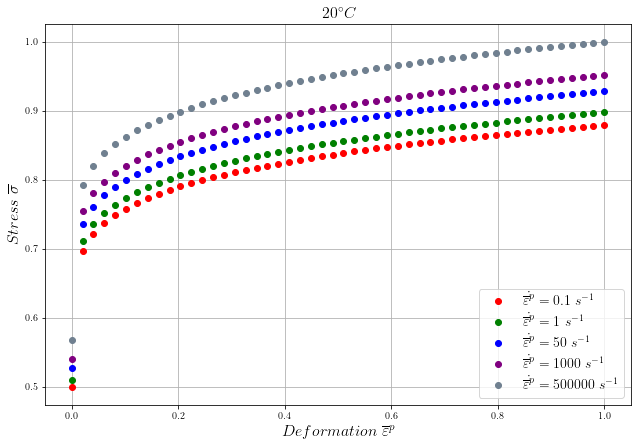

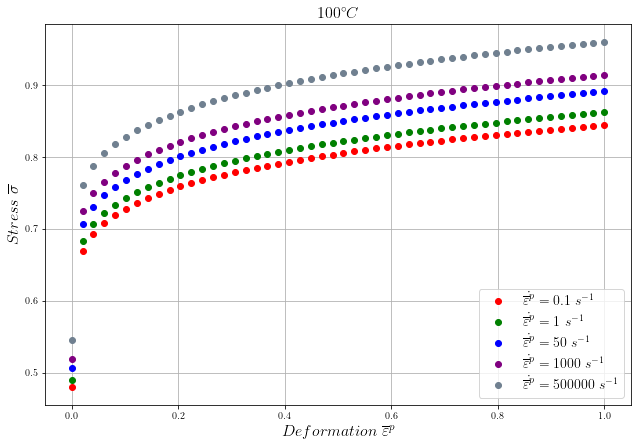

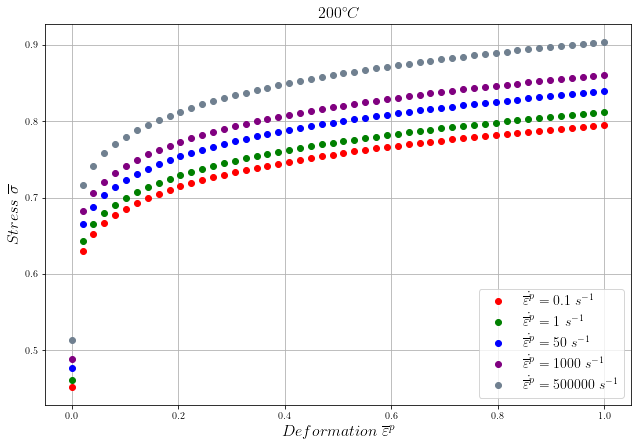

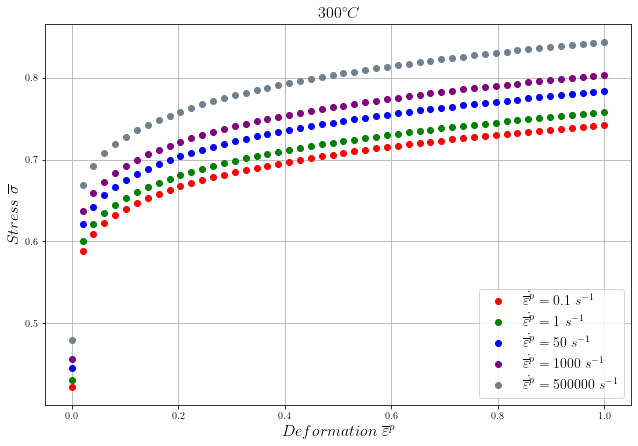

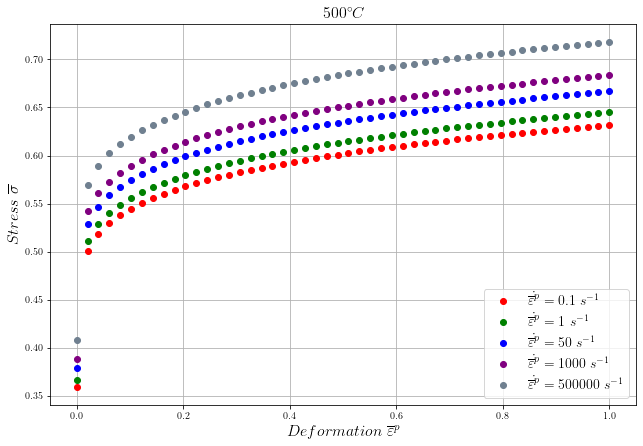

In [39]:
for T in temperatures:
    plt.figure(figsize = (10.5, 7))
    plt.rc('text', usetex = True)
    cl = 0
    for epspv, epspvv in zip(epsp,epspOrig):
        # filter on T
        data = NNentries[(entries[:,colT]==T) & (entries[:,colEpsp]==epspv), :]
        # Plot the curves
        plt.plot(data[:,colEps], data[:,colSig], colors[cl], label=r'$\dot{\overline{\varepsilon}^p}=' + str(epspvv) + '\ s^{-1}$', marker = 'o', linestyle='none')
        cl += 1
    plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
    plt.grid() # Plot the grid with default size
    plt.xlabel(r'$Deformation\ \overline{\varepsilon}^{p}$', fontsize = 16) # Labels the x axis
    plt.ylabel(r'$Stress\ \overline{\sigma}$', fontsize = 16) # Labels the y axis
    plt.title(r'$' + str(T) + '^{\circ}C$', fontsize = 16) # Self explicit command
    plt.savefig('OriginalData'+str(T)+'.svg', bbox_inches = 'tight', pad_inches = 0)
    plt.show()

## Mise en forme des données pour le RNN

In [15]:
T = 20
#epspv = 0.1
#data = NNentries[(entries[:,colT]==T) & (entries[:,colEpsp]==epspv), :]
#data = NNentries[(entries[:,colT]==T), :]
NNinput = NNentries[:,colEps:colSig]#.reshape(250,2)
NNoutput = NNentries[:,colSig]#.reshape(250,1)
NNinput.shape, NNoutput.shape

((1250, 3), (1250,))

Construction du Réseau de Neurones

In [16]:
# Importation de TensorFlow 
import numpy as np
from keras.models import Sequential
from keras.metrics import MeanSquaredError
from keras.layers.core import Dense, Activation
from keras import optimizers

In [17]:
models = []
convergenceCurves = []
modelsDescription = []

In [18]:
#Création du modèle 1
model=Sequential()
model.add(Dense(6, input_dim=3, activation='sigmoid'))
model.add(Dense(1))
#model.summary()
models.append(model)
modelsDescription.append("3-6-1 sigmoid")

In [19]:
#Création du modèle 2
model=Sequential()
model.add(Dense(6, input_dim=3, activation='tanh'))
model.add(Dense(1))
#model.summary()
models.append(model)
modelsDescription.append("3-6-1 tanh")

In [20]:
#Création du modèle 2
model=Sequential()
model.add(Dense(4, input_dim=3, activation='tanh'))
model.add(Dense(1))
#model.summary()
models.append(model)
modelsDescription.append("3-4-1 tanh")

In [21]:
#Création du modèle 1
model=Sequential()
model.add(Dense(4, input_dim=3, activation='sigmoid'))
model.add(Dense(1))
#model.summary()
models.append(model)
modelsDescription.append("3-4-1 sigmoid")

In [22]:
#Création du modèle
model=Sequential()
model.add(Dense(4, input_dim=3, activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1))
#model.summary()
models.append(model)
modelsDescription.append("3-4-2-1 tanh")

In [23]:
#Création du modèle
model=Sequential()
model.add(Dense(4, input_dim=3, activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))
model.add(Dense(1))
#model.summary()
models.append(model)
modelsDescription.append("3-4-2-1 sigmoid")

In [24]:
for model in models:
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [25]:
#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='mse', optimizer='adams', metrics=[MeanSquaredError()])

In [26]:
j = 1
epochs = 100
for model in models:
    hist = []
    print("MODEL :", modelsDescription[j-1])
    for i in range(epochs):
        history=model.fit(NNinput, NNoutput, epochs=100, verbose=0)
        loss = history.history['loss'][-1]
        hist.append(loss)
        print("Epoch :", i+1, "/",epochs,"->",loss,"         ", end='\r')
    print("\n")
    convergenceCurves.append(hist)
    j+=1

MODEL : 3-6-1 sigmoid
Epoch : 100 / 100 -> 2.829862296493957e-06          

MODEL : 3-6-1 tanh
Epoch : 100 / 100 -> 1.7188162928505335e-06          

MODEL : 3-4-1 tanh
Epoch : 100 / 100 -> 1.4799747077631764e-05          

MODEL : 3-4-1 sigmoid
Epoch : 100 / 100 -> 2.9604959763673833e-06          

MODEL : 3-4-2-1 tanh
Epoch : 100 / 100 -> 9.23497793792194e-07           

MODEL : 3-4-2-1 sigmoid
Epoch : 100 / 100 -> 1.7826596376835369e-06          



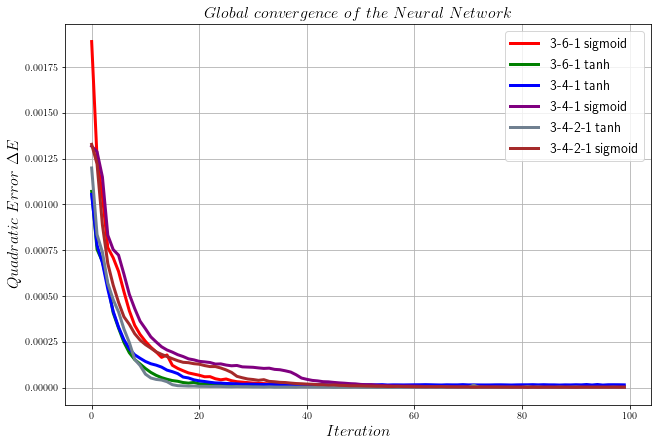

In [34]:
plt.figure(figsize = (10.5, 7))
plt.rc('text', usetex = True)
i=0
for model in models:
    plt.plot(convergenceCurves[i], color = colors[i], label=modelsDescription[i],linewidth=3)
    i+=1
#    plt.plot(hist, color = 'purple', linewidth=3)
plt.grid() # Plot the grid with default size
plt.xlabel(r'$Iteration$', fontsize = 16) # Labels the x axis
plt.ylabel(r'$Quadratic\ Error\ \Delta E$', fontsize = 16) # Labels the y axis
plt.title(r'$Global\ convergence\ of\ the\ Neural\ Network$', fontsize = 16) # Self explicit command
plt.legend(loc = 'upper right',fancybox = True, numpoints = 1, fontsize = 14)
plt.savefig('Convergence.svg', bbox_inches = 'tight', pad_inches = 0)
plt.show()

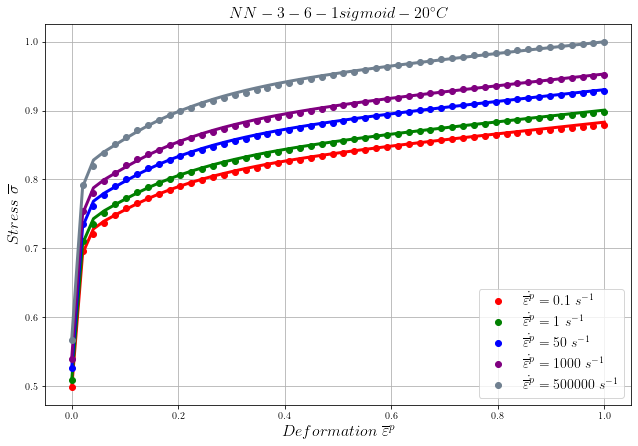

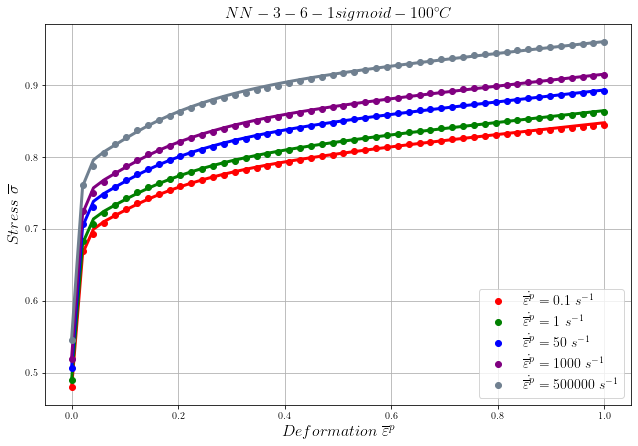

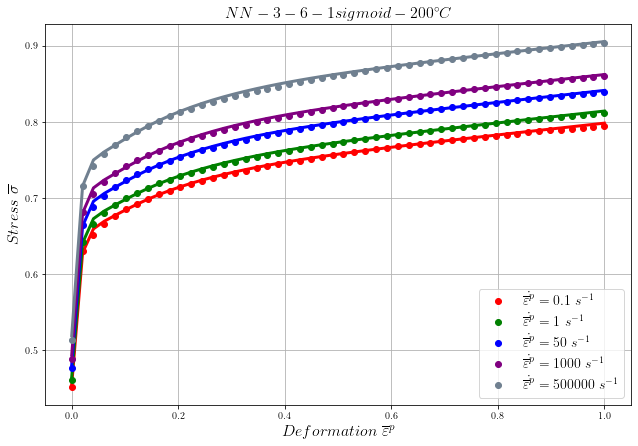

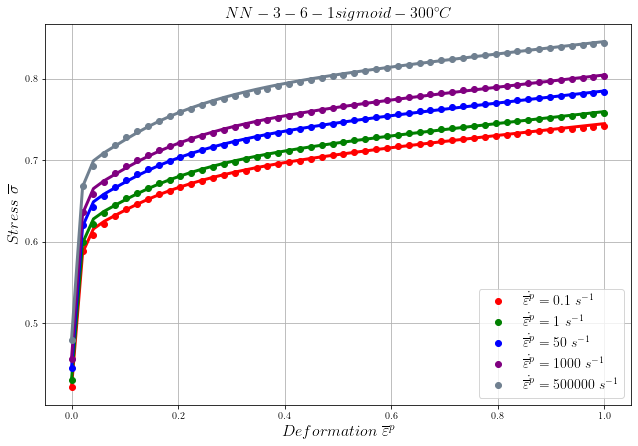

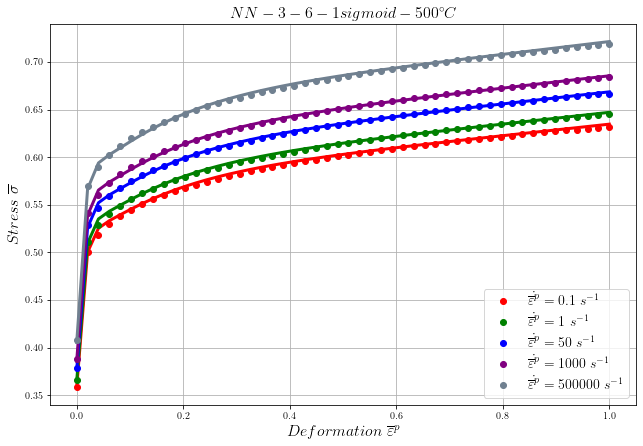

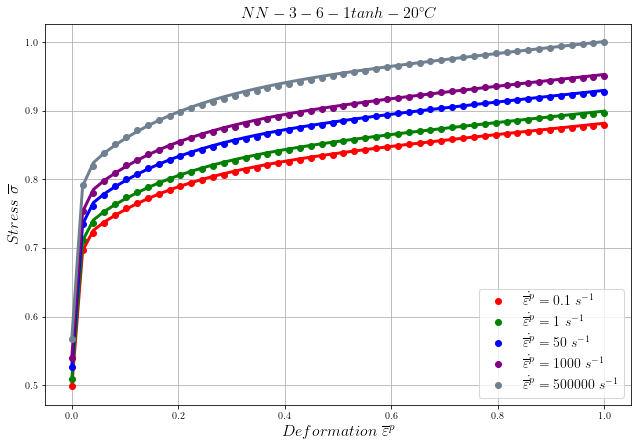

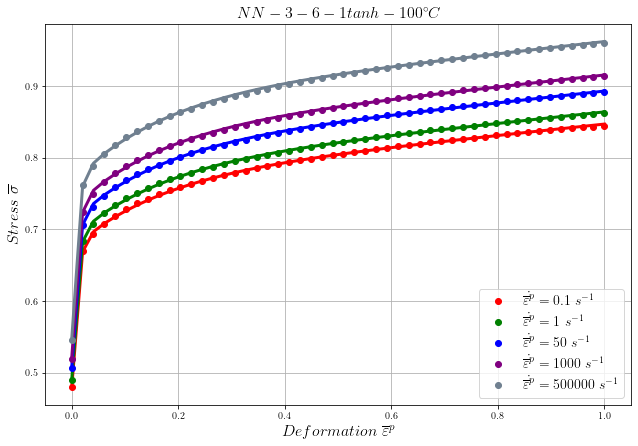

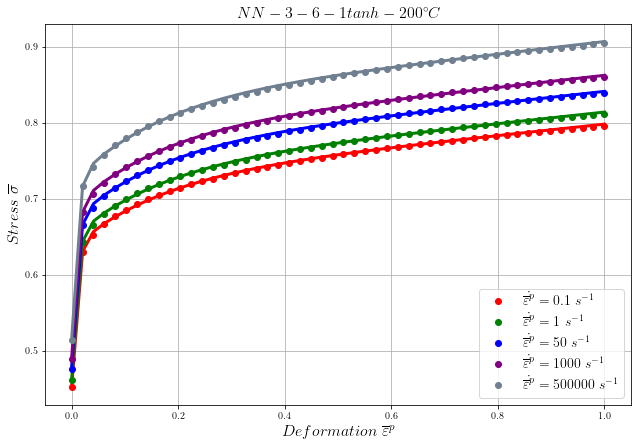

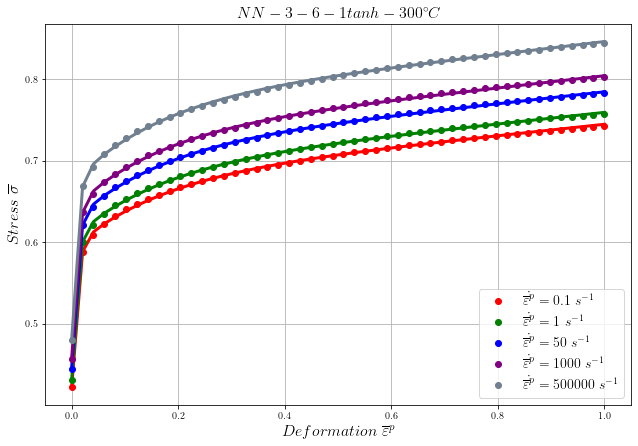

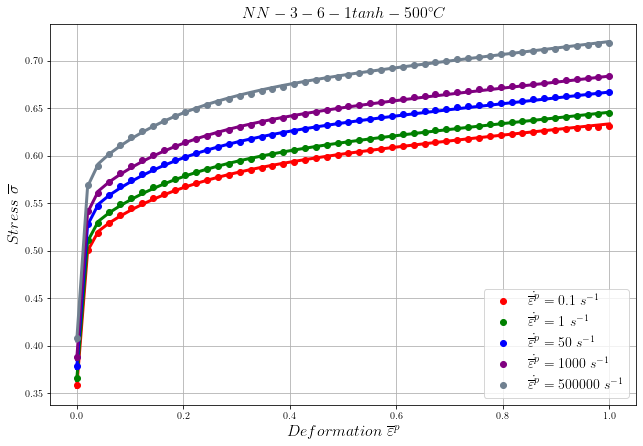

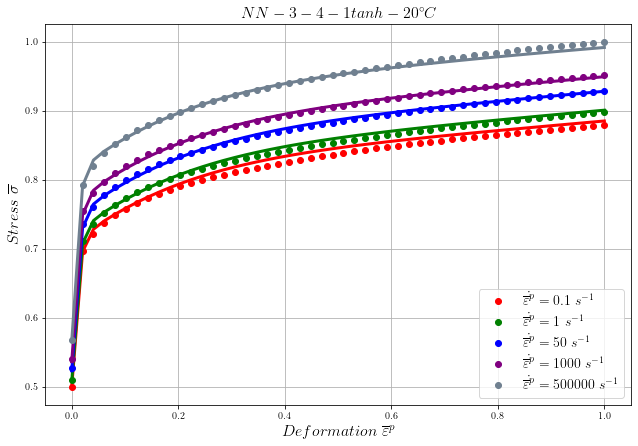

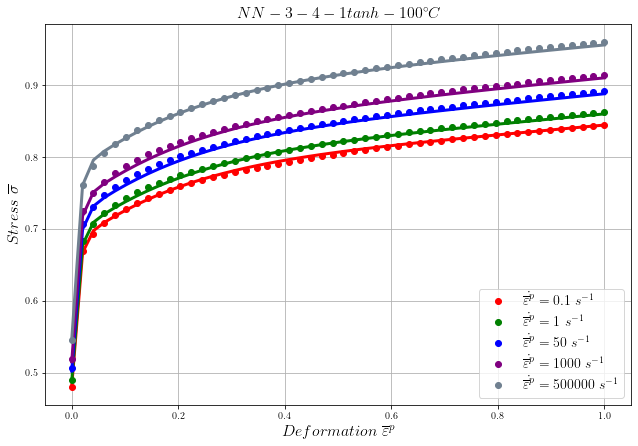

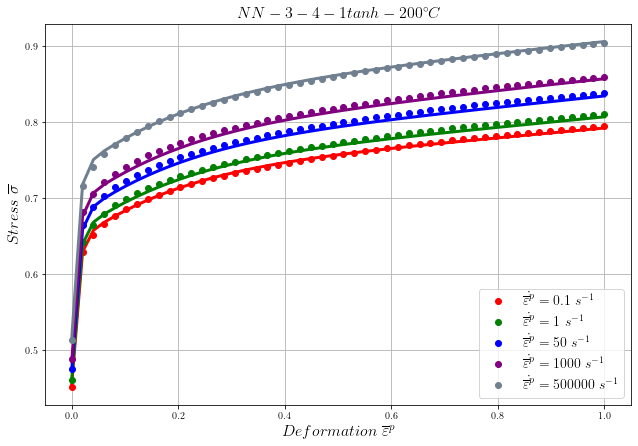

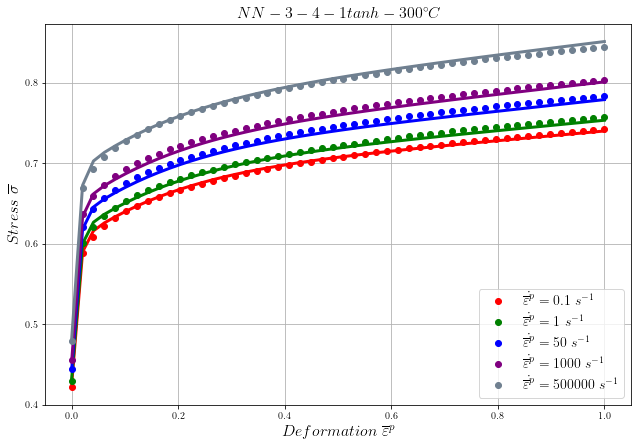

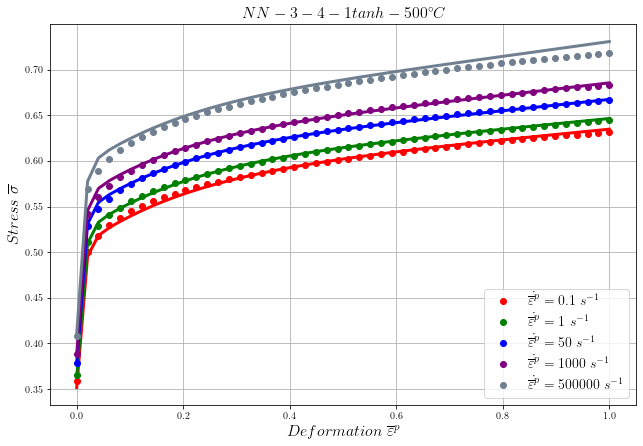

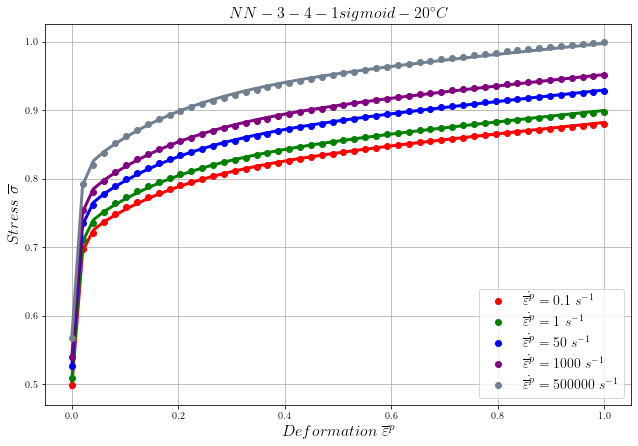

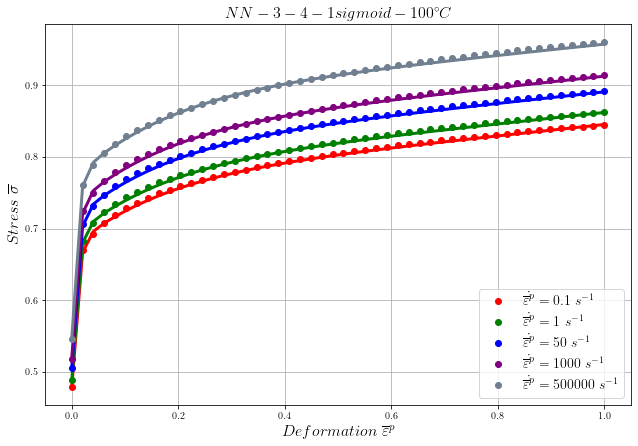

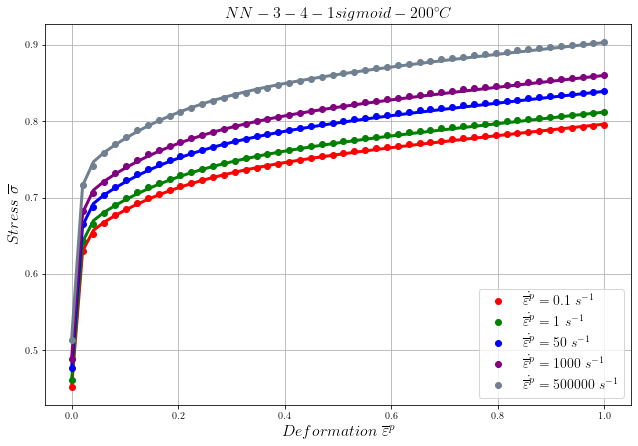

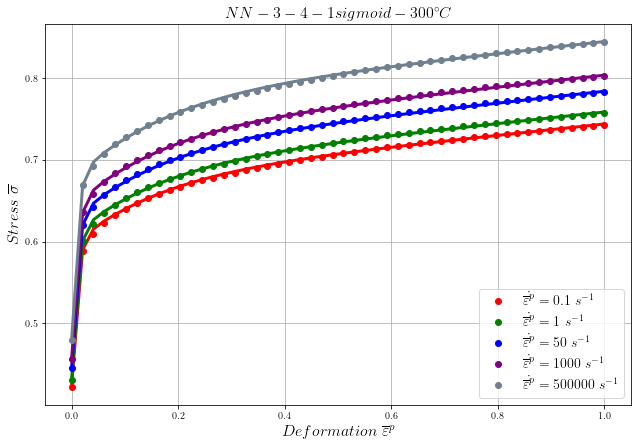

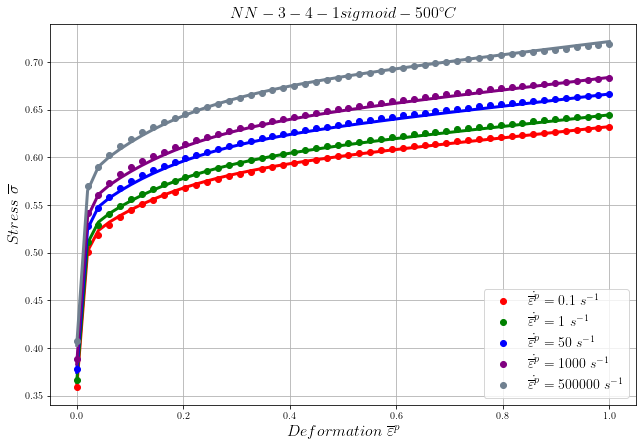

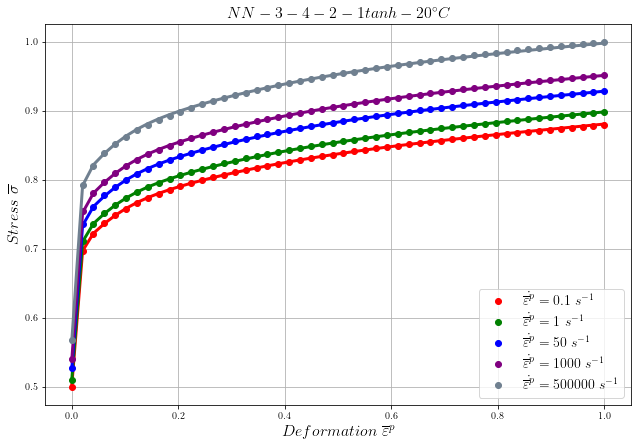

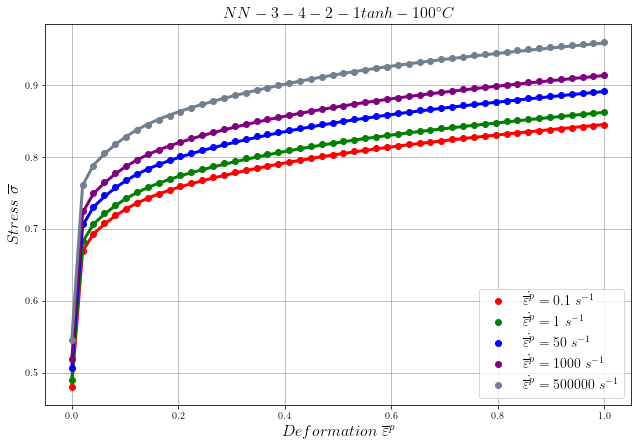

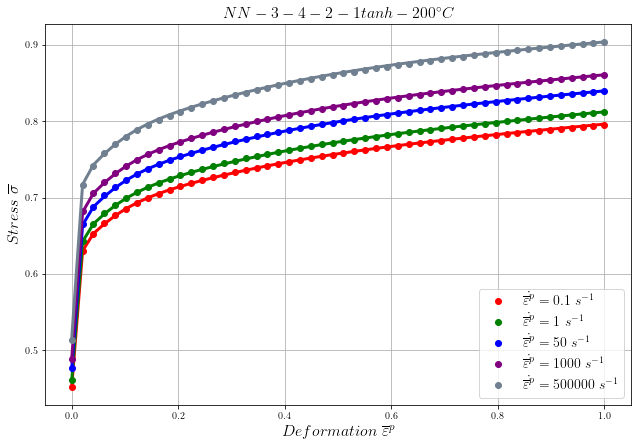

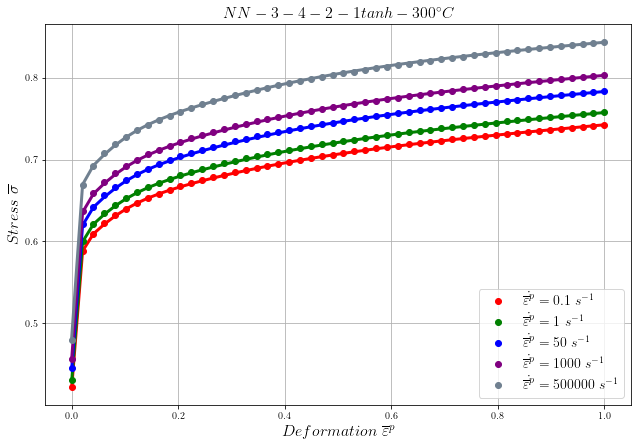

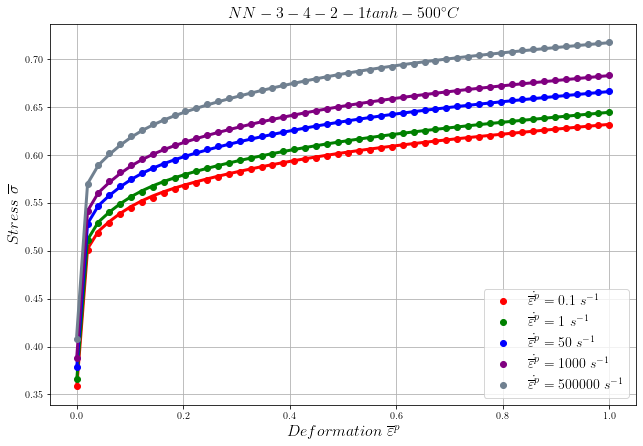

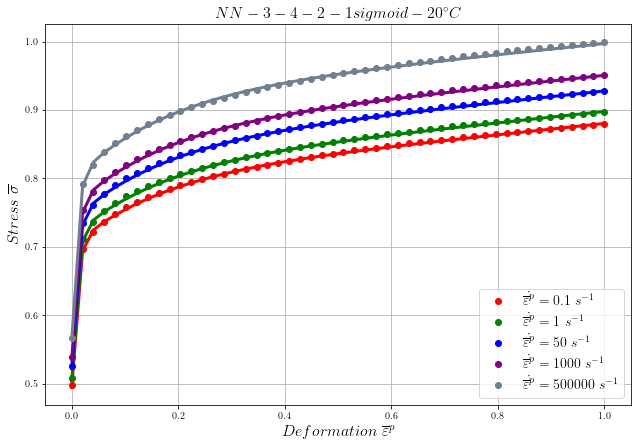

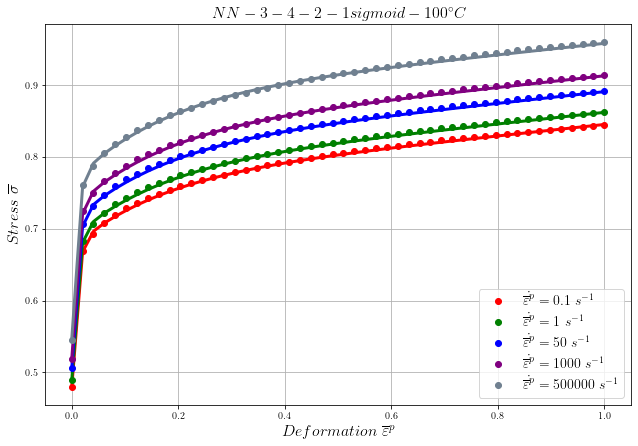

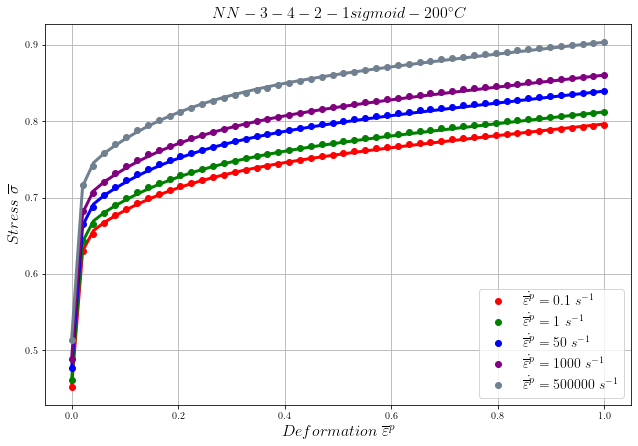

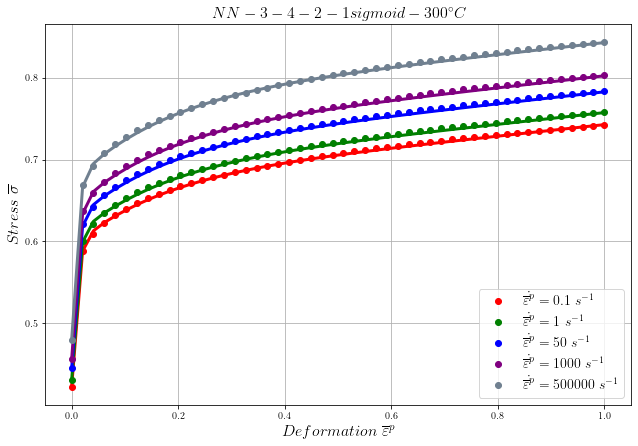

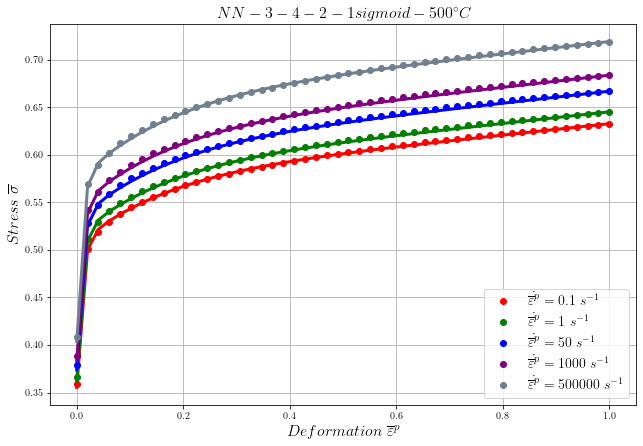

In [47]:
i=0
for model in models:
    predictedOutput = model.predict(NNinput)
    plotPredicted=predictedOutput.reshape(25,50).T
    plotPredicted
    pcol = 0
    for T, TOrig in zip(temperatures,temperaturesOrig):
        cl = 0
        plt.figure(figsize = (10.5, 7))
        plt.rc('text', usetex = True)
        for epspv, epspvAff in zip(epsp,epspOrig):
            # filter on T
            data = NNentries[(entries[:,colT]==T) & (entries[:,colEpsp]==epspv), :]
            # Plot the curves
            plt.plot(data[:,colEps], data[:,colSig], colors[cl], label=r'$\dot{\overline{\varepsilon}^p}=' + str(epspvAff) + '\ s^{-1}$', marker = 'o', linestyle='none')
            plt.plot(data[:,colEps], plotPredicted[:,pcol], colors[cl], linewidth = 3)
            cl += 1
            pcol += 1
        plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
        plt.grid() # Plot the grid with default size
        plt.xlabel(r'$Deformation\ \overline{\varepsilon}^{p}$', fontsize = 16) # Labels the x axis
        plt.ylabel(r'$Stress\ \overline{\sigma}$', fontsize = 16) # Labels the y axis
        plt.title(r'$NN-'+modelsDescription[i] +'-'+ str(T) + '^{\circ}C$', fontsize = 16) # Self explicit command
        plt.savefig('NN-'+modelsDescription[i]+str(T)+'.svg', bbox_inches = 'tight', pad_inches = 0)
        plt.show()
    i+=1

In [41]:
predictedOutput = model.predict(NNinput)
plotPredicted=predictedOutput.reshape(25,50).T
plotPredicted

array([[0.49475706, 0.50484383, 0.522411  , ..., 0.37385488, 0.3833288 ,
        0.40367007],
       [0.6945621 , 0.7081753 , 0.7318574 , ..., 0.5257219 , 0.5387293 ,
        0.5666585 ],
       [0.72490466, 0.7391778 , 0.764007  , ..., 0.54855025, 0.56215894,
        0.5913842 ],
       ...,
       [0.8770369 , 0.89455163, 0.9244417 , ..., 0.66410565, 0.68093765,
        0.71626496],
       [0.87871635, 0.89624214, 0.9261378 , ..., 0.66538036, 0.6822295 ,
        0.7175703 ],
       [0.88039386, 0.89793026, 0.92783   , ..., 0.666654  , 0.68351996,
        0.71887314]], dtype=float32)

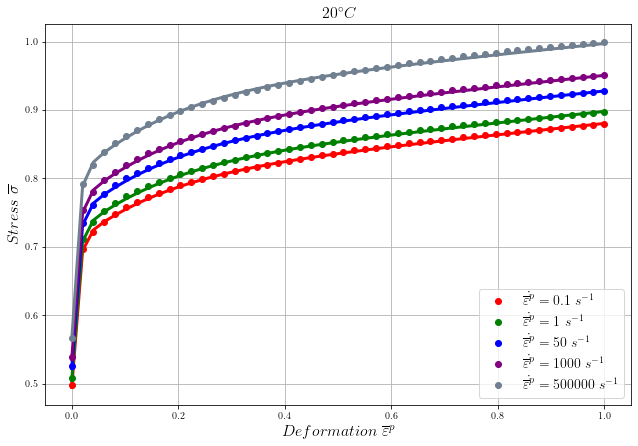

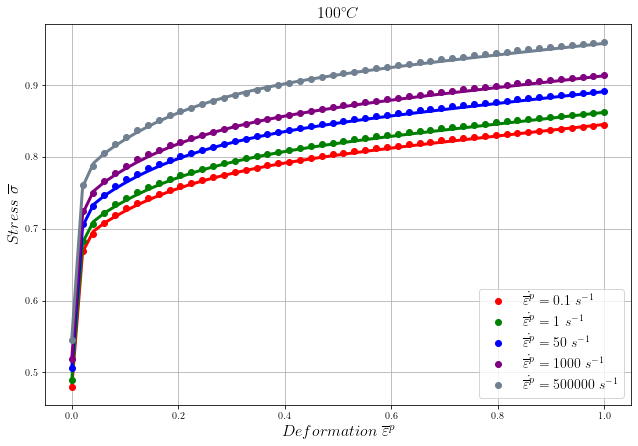

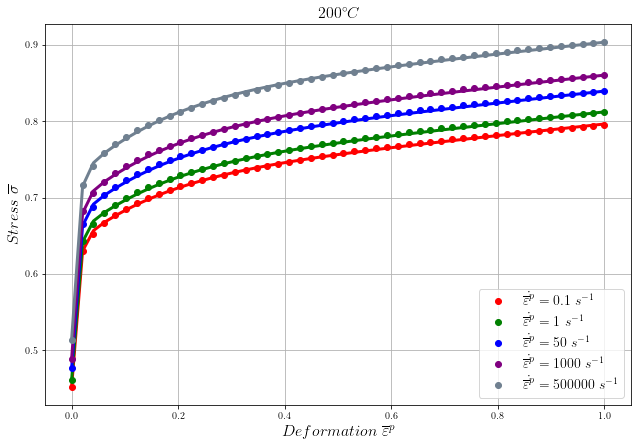

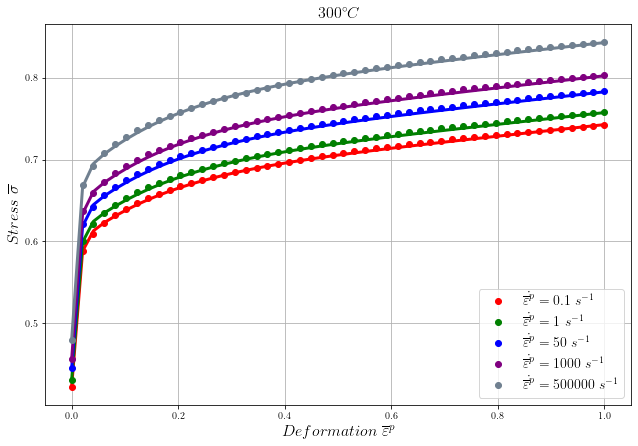

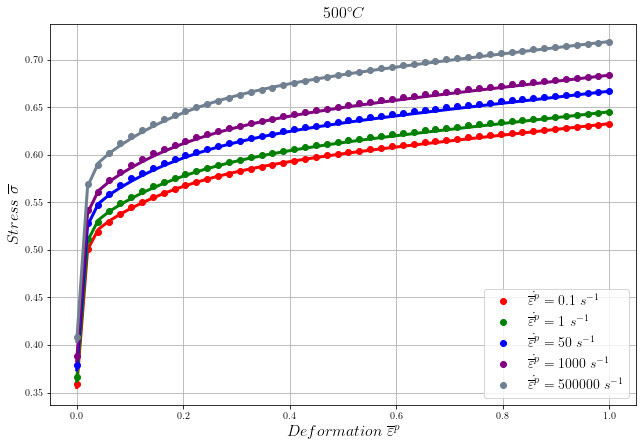

In [42]:
pcol = 0
for T, TOrig in zip(temperatures,temperaturesOrig):
    cl = 0
    plt.figure(figsize = (10.5, 7))
    plt.rc('text', usetex = True)
    for epspv, epspvAff in zip(epsp,epspOrig):
        # filter on T
        data = NNentries[(entries[:,colT]==T) & (entries[:,colEpsp]==epspv), :]
        # Plot the curves
        plt.plot(data[:,colEps], data[:,colSig], colors[cl], label=r'$\dot{\overline{\varepsilon}^p}=' + str(epspvAff) + '\ s^{-1}$', marker = 'o', linestyle='none')
        plt.plot(data[:,colEps], plotPredicted[:,pcol], colors[cl], linewidth = 3)
        cl += 1
        pcol += 1
    plt.legend(loc = 'lower right',fancybox = True, numpoints = 1, fontsize = 14)
    plt.grid() # Plot the grid with default size
    plt.xlabel(r'$Deformation\ \overline{\varepsilon}^{p}$', fontsize = 16) # Labels the x axis
    plt.ylabel(r'$Stress\ \overline{\sigma}$', fontsize = 16) # Labels the y axis
    plt.title(r'$' + str(T) + '^{\circ}C$', fontsize = 16) # Self explicit command
    #plt.savefig('NN-Performance'+str(T)+'.svg', bbox_inches = 'tight', pad_inches = 0)
    plt.show()

In [31]:
i=1
for layer in model.layers:
    print("\nLayer ",i)
    W = layer.get_weights()
    w = W[0]
    b = W[1]
    print("Weights : ", w.shape, w)
    print("Bias : ", b.shape, b)
    np.save('W'+str(i)+'.npy', w)
    np.save('b'+str(i)+'.npy', b)
    i+=1


Layer  1
Weights :  (3, 6) [[ -6.94815    -82.36453    -53.850216     0.09839702   0.29597342
   -0.2828883 ]
 [  0.24262452   0.15178692   0.2796177    0.11806463   0.42124844
   -0.4491785 ]
 [ -0.3839296   -0.30996475  -0.24854748  -1.3494258   -0.6265573
   -2.020304  ]]
Bias :  (6,) [-1.6851751  -2.7820692  -1.2710196   0.54943    -0.74834245 -0.30530235]

Layer  2
Weights :  (6, 1) [[-0.64596754]
 [-5.1055636 ]
 [ 0.41804826]
 [ 0.75323933]
 [ 0.6857289 ]
 [-0.28005978]]
Bias :  (1,) [0.23027954]
